In [229]:
%pip install pandas numpy matplotlib scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, random, time


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Provide sensor data recording to run the processing/analysis on

In [230]:
import config
from importlib import reload
reload(config)
from config import *

### Cut off debug data from flashing if there's any left

In [231]:
HEADERS = "time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z"
lines = []
cutting = False
with open(SENSOR_DATA, 'r') as file:
    found_start = False
    for (i, line) in enumerate(file.readlines()):
        if not found_start and HEADERS in line:
            if i == 0:
                break
            found_start = True
            cutting = True
        if found_start:
            lines.append(line)
if cutting:
    with open(SENSOR_DATA, 'w') as file:
        file.writelines(lines[:-1])

### Run the sensor processing code

In [232]:
result = os.system(f'RUST_LOG=debug cargo run --release -- {SENSOR_DATA}')
if result != 0:
    raise Exception('Failed to compile sensor data')

   Compiling lib-processing v0.1.0 (/home/matt/School/TU Delft/CESE4065 Avanced Practical IOT/gait-analyzer/lib-processing)
   Compiling test-processing v0.1.0 (/home/matt/School/TU Delft/CESE4065 Avanced Practical IOT/gait-analyzer/test-processing)
    Finished `release` profile [optimized] target(s) in 0.79s
     Running `target/release/test-processing recordings/bling2_trot.csv`
[2024-12-13T15:48:04Z DEBUG lib_processing::step_detection] Step started: 72114380800
[2024-12-13T15:48:04Z DEBUG lib_processing::step_detection] Peak passed: 72419729408
[2024-12-13T15:48:04Z DEBUG lib_processing::step_detection] Minimum velocity sum: -6.2821174
[2024-12-13T15:48:04Z DEBUG lib_processing::step_detection] Step ended: 72578031616
[2024-12-13T15:48:04Z WARN  lib_processing::step_detection] Reset position and velocity after last step: 72596176896
[2024-12-13T15:48:04Z DEBUG lib_processing::step_detection] Step started: 72929574912
[2024-12-13T15:48:04Z DEBUG lib_processing::step_detection] Peak

### Load sensor data

In [233]:
data = pd.read_csv(SENSOR_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
now = time.time()
data['t'] = pd.to_datetime((data['time'] / 1_000_000_000.0) + now, unit='s')
data.set_index(data['t'], inplace=True)
data.drop(columns=['t'], inplace=True)
data

,time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z
t,,,,,,,
2024-12-13 15:49:16.815991163,72021455000,-2.092800,0.813601,-0.363965,1.429338,4.692636,14.369999
2024-12-13 15:49:16.825227022,72030691000,-2.073644,0.781142,-0.365561,1.841141,5.322310,13.682862
2024-12-13 15:49:16.834336996,72039801000,-2.025221,0.714627,-0.360772,2.126051,6.617573,11.805809
2024-12-13 15:49:16.843469143,72048933000,-2.000212,0.678444,-0.333103,2.073379,7.168240,10.647015
2024-12-13 15:49:16.852646112,72058110000,-1.982120,0.673655,-0.293726,1.122881,6.924031,8.327033
...,...,...,...,...,...,...,...
2024-12-13 15:49:27.956587076,83162051000,-2.607353,1.400521,-0.326185,2.430115,7.103596,15.471332
2024-12-13 15:49:27.965815067,83171279000,-2.579683,1.361145,-0.349598,3.320758,8.465898,14.741100
2024-12-13 15:49:27.974969149,83180433000,-2.554141,1.312722,-0.345873,4.309563,10.029311,13.728353


### Load algorithm debug data

In [234]:
algo = pd.read_csv(ALGORITHM_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
algo['t'] = pd.to_datetime((algo['time'] / 1_000_000_000.0) + now, unit='s')
algo.set_index(algo['t'], inplace=True)
algo.drop(columns=['t'], inplace=True)
algo.head()

,time,orientation.w,orientation.x,orientation.y,orientation.z,velocity.x,velocity.y,velocity.z,position.x,position.y,...,world_acc.y,world_acc.z,gyro_orientation.w,gyro_orientation.x,gyro_orientation.y,gyro_orientation.z,accel_orientation.w,accel_orientation.x,accel_orientation.y,accel_orientation.z
t,,,,,,,,,,,,,,,,,,,,,
2024-12-13 15:49:16.815994978,72021458944,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-12-13 15:49:16.825227499,72030691328,0.999965,-0.007637,0.002958,-0.001556,0.017899,0.051006,0.034919,0.000165,0.000471,...,5.524722,3.782186,0.999946,-0.009572,0.003606,-0.001687,0.980936,0.184063,-0.061267,0.011496
2024-12-13 15:49:16.834336996,72039800832,0.999880,-0.014179,0.005401,-0.002969,0.038784,0.114192,0.051162,0.000519,0.001511,...,6.936209,1.783092,0.999794,-0.018796,0.006860,-0.003328,0.964615,0.251912,-0.075304,0.019666
2024-12-13 15:49:16.843471050,72048934912,0.999758,-0.020178,0.007659,-0.004209,0.059756,0.183364,0.055814,0.001064,0.003186,...,7.572947,0.509369,0.999549,-0.027928,0.009959,-0.004845,0.953365,0.291027,-0.076507,0.023355
2024-12-13 15:49:16.852646112,72058109952,0.999606,-0.025596,0.010173,-0.005321,0.072273,0.250592,0.038658,0.001727,0.005485,...,7.327249,-1.869851,0.999210,-0.037014,0.013054,-0.006187,0.939200,0.339466,-0.048561,0.017552


## Load detected steps

In [235]:
steps = pd.read_csv(STEPS_DATA)
steps

,start,peak,finished,peak.x,peak.y,peak.z,velocity.x,velocity.y,velocity.z
0,72114380800,72457338880,72578031616,NaN,NaN,NaN,NaN,NaN,NaN
1,72929574912,73287491584,73407782912,NaN,NaN,NaN,NaN,NaN,NaN
2,73759793152,74129842176,74223075328,NaN,NaN,NaN,NaN,NaN,NaN
3,74591977472,74943791104,75036418048,NaN,NaN,NaN,NaN,NaN,NaN
4,75406450688,75748753408,75878531072,NaN,NaN,NaN,NaN,NaN,NaN
5,76194021376,76561620992,76655190016,NaN,NaN,NaN,NaN,NaN,NaN
6,76978970624,77348290560,77421944832,NaN,NaN,NaN,NaN,NaN,NaN
7,77726539776,78061281280,78212718592,NaN,NaN,NaN,NaN,NaN,NaN
8,78526513152,78904229888,79034499072,NaN,NaN,NaN,NaN,NaN,NaN
9,79348490240,79693938688,79833710592,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
# Convert ESP32 system time to local time so the graphs make more sense.
steps['start'] = pd.to_datetime((steps['start'] / 1_000_000_000.0) + now, unit='s')
steps['peak'] = pd.to_datetime((steps['peak'] / 1_000_000_000.0) + now, unit='s')
steps['finished'] = pd.to_datetime((steps['finished'] / 1_000_000_000.0) + now, unit='s')

### Preview raw sensor data

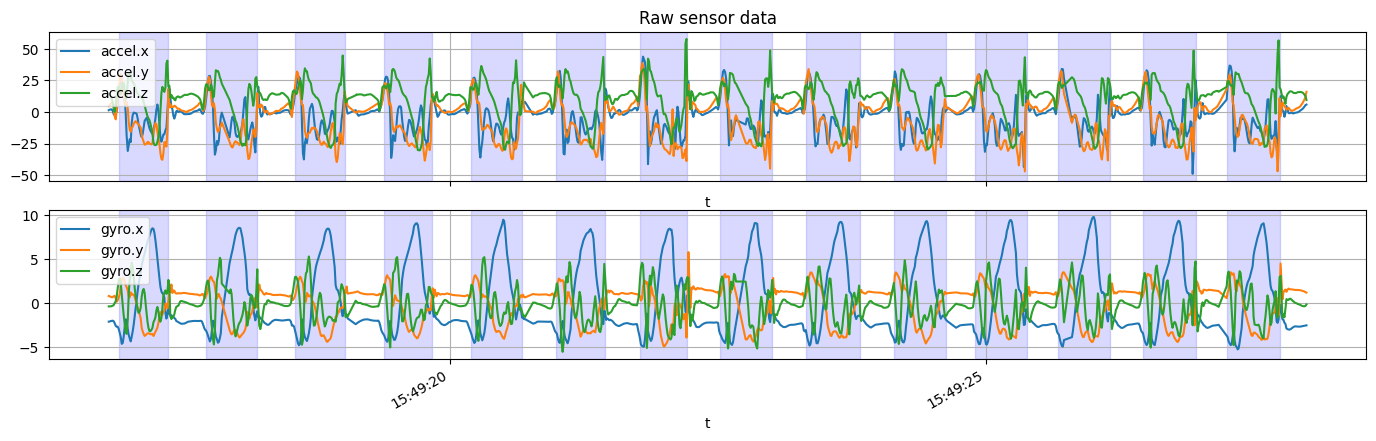

In [237]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel.x'].plot(ax=ax1)
data['accel.y'].plot(ax=ax1)
data['accel.z'].plot(ax=ax1)
ax1.xaxis.set_ticklabels([])
ax1.legend(loc='upper left')
ax1.grid()

data['gyro.x'].plot(ax=ax2)
data['gyro.y'].plot(ax=ax2)
data['gyro.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()

ax1.set_title('Raw sensor data')
fig.set_figwidth(17)

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

### Gravity vector length

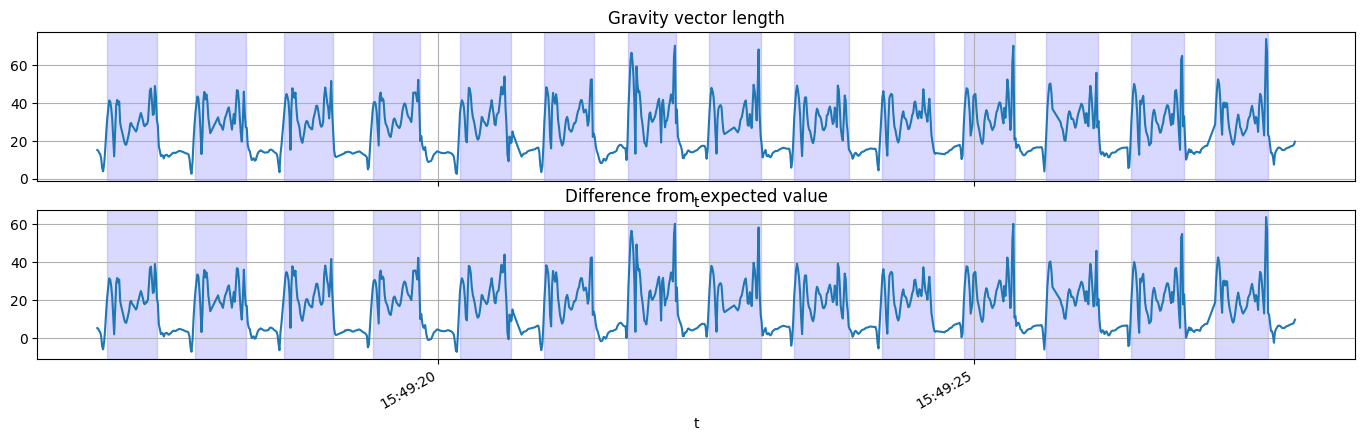

In [238]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel._length'] = np.sqrt(data['accel.x'] ** 2 + data['accel.y'] ** 2 + data['accel.z'] ** 2)
data['accel._length'].plot(ax=ax1)
ax1.grid()
ax1.set_title('Gravity vector length')
ax1.xaxis.set_ticklabels([])

data['gravity_delta'] = data['accel._length'] - 9.80665
data['gravity_delta'].plot(ax=ax2)
ax2.grid()
ax2.set_title('Difference from expected value')

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)

### Preview computed position, velocity, acceleration

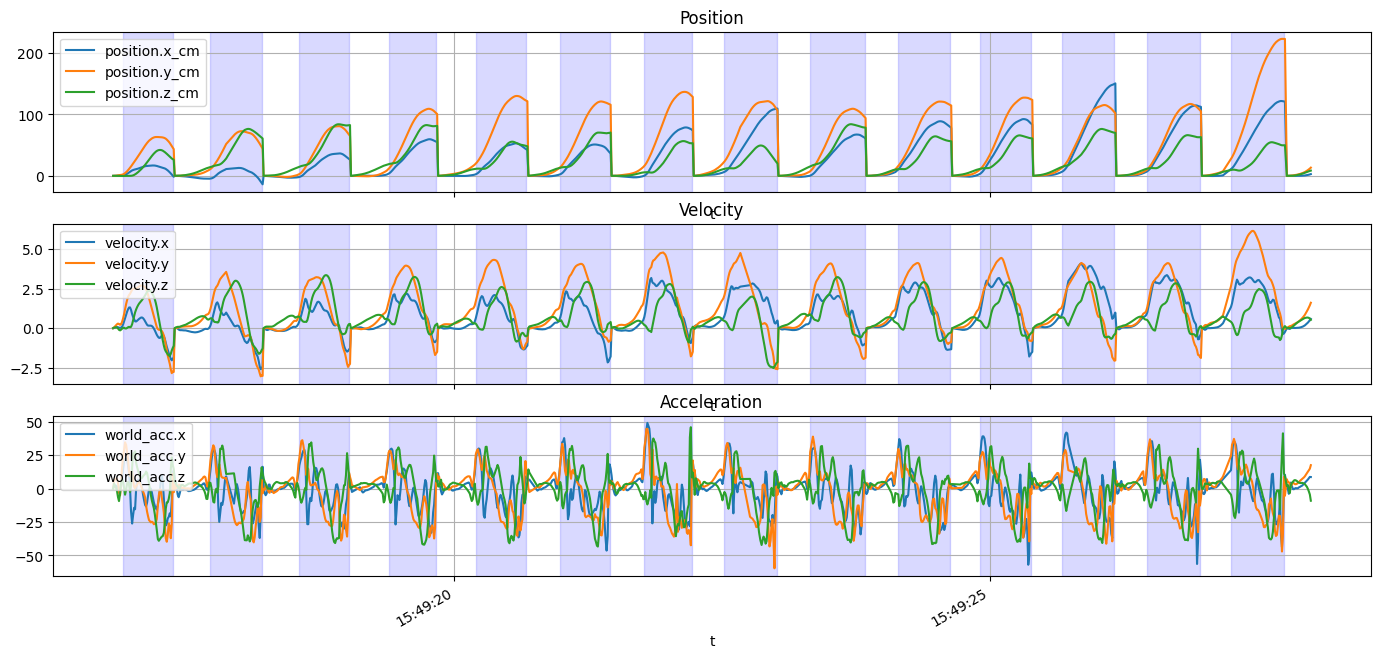

In [239]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Velocity')
ax2.xaxis.set_ticklabels([])

algo['world_acc.x'].plot(ax=ax3)
algo['world_acc.y'].plot(ax=ax3)
algo['world_acc.z'].plot(ax=ax3)
ax3.legend(loc='upper left')

ax3.grid()
ax3.set_title('Acceleration')

for ax in [ax1, ax2, ax3]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
fig.set_figheight(8)

### Load Euler angles

In [240]:
angles = pd.read_csv(ANGLES_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
angles['t'] = pd.to_datetime((angles['time'] / 1_000_000_000.0) + now, unit='s')
angles.set_index(angles['t'], inplace=True)
angles.drop(columns=['t'], inplace=True)
angles.head()

,time,fusion.yaw,fusion.pitch,fusion.roll,gyro.yaw,gyro.pitch,gyro.roll,accel.yaw,accel.pitch,accel.roll,gyro.x,gyro.y,gyro.z,gyro.w
t,,,,,,,,,,,,,,
2024-12-13 15:49:16.815994978,72021458944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-12-13 15:49:16.825227499,72030691328,-0.180886,0.337559,-0.875729,-0.197320,0.411329,-1.097624,0.0,-7.147870,21.254858,-0.009572,0.003606,-0.001687,0.999946
2024-12-13 15:49:16.834336996,72039800832,-0.348998,0.614039,-1.626711,-0.396144,0.778816,-2.156729,0.0,-8.927606,29.272163,-0.018796,0.006860,-0.003328,0.999794
2024-12-13 15:49:16.843471050,72048934912,-0.499924,0.867691,-2.316297,-0.586916,1.125327,-3.206703,0.0,-9.176197,33.950924,-0.027928,0.009959,-0.004845,0.999549
2024-12-13 15:49:16.852646112,72058109952,-0.639484,1.149739,-2.940046,-0.764077,1.468662,-4.252700,0.0,-5.919594,39.743940,-0.037014,0.013054,-0.006187,0.999210


### Compare orientations

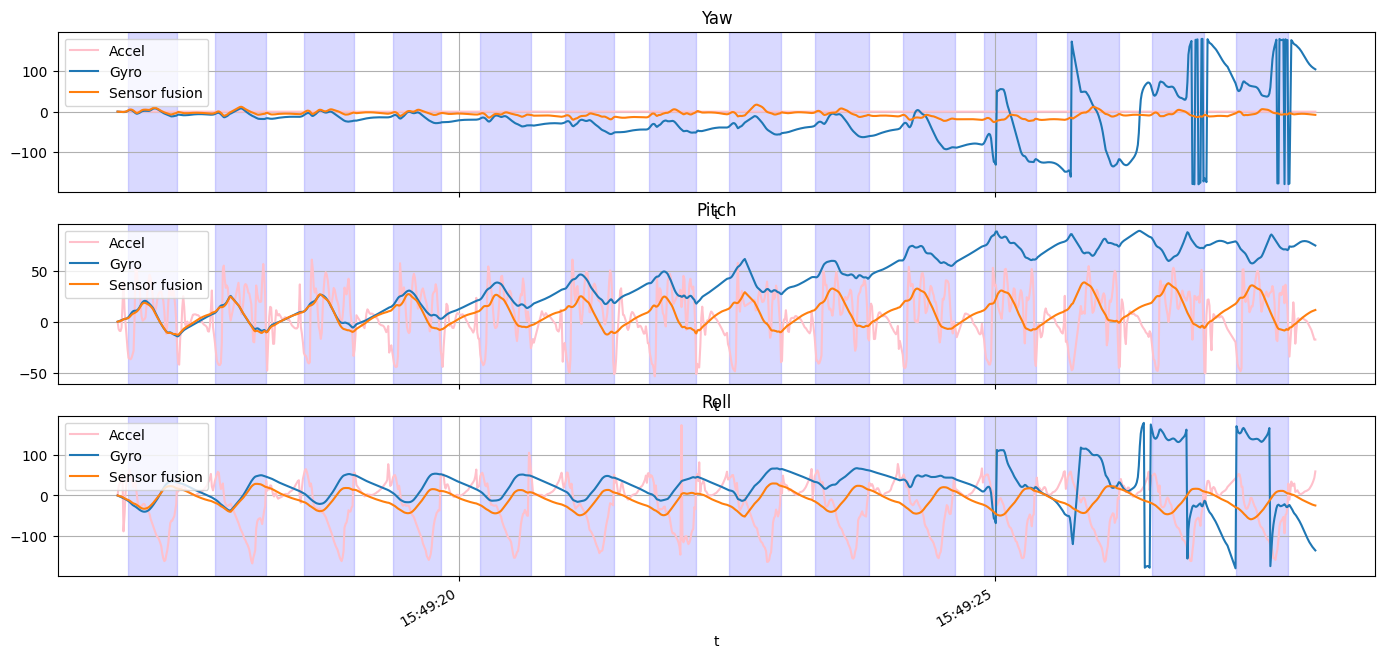

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

angles['accel.yaw'].plot(ax=ax1, label='Accel', color='pink')
angles['gyro.yaw'].plot(ax=ax1, label='Gyro')
angles['fusion.yaw'].plot(ax=ax1, label='Sensor fusion')
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Yaw')
ax1.xaxis.set_ticklabels([])

angles['accel.pitch'].plot(ax=ax2, label='Accel', color='pink')
angles['gyro.pitch'].plot(ax=ax2, label='Gyro')
angles['fusion.pitch'].plot(ax=ax2, label='Sensor fusion')
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Pitch')
ax2.xaxis.set_ticklabels([])

angles['accel.roll'].plot(ax=ax3, label='Accel', color='pink')
angles['gyro.roll'].plot(ax=ax3, label='Gyro')
angles['fusion.roll'].plot(ax=ax3, label='Sensor fusion')
ax3.legend(loc='upper left')
ax3.grid()
ax3.set_title('Roll')

for ax in [ax1, ax2, ax3]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
fig.set_figheight(8)

### Review quaternion values from gyro

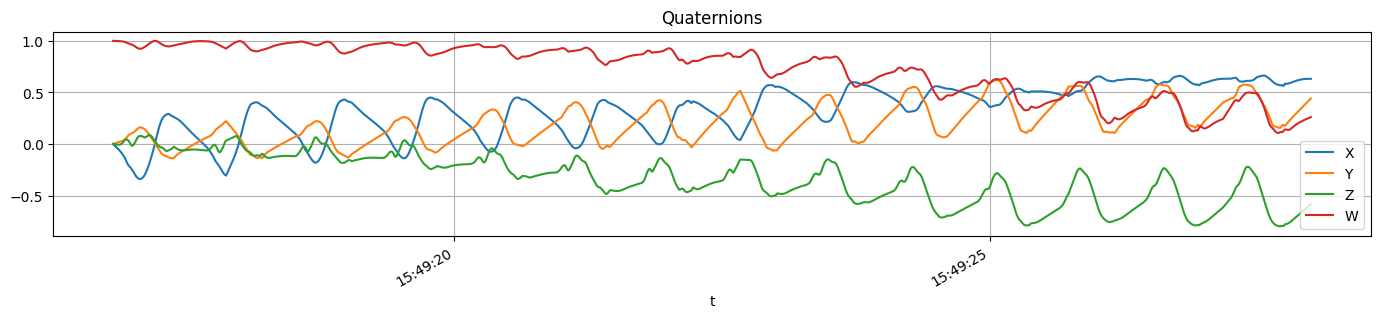

In [242]:
fig, ax1 = plt.subplots(1, 1)

angles['gyro.x'].plot(ax=ax1, label='X')
angles['gyro.y'].plot(ax=ax1, label='Y')
angles['gyro.z'].plot(ax=ax1, label='Z')
angles['gyro.w'].plot(ax=ax1, label='W')
ax1.grid()
ax1.set_title('Quaternions')
ax1.legend()

fig.set_figwidth(17)
fig.set_figheight(3)

### Packets per second

<Axes: xlabel='t'>

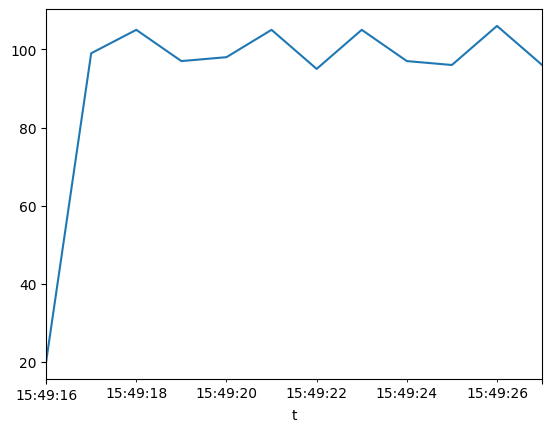

In [243]:
packets = data.resample('1s').count()
packets.drop(columns=['gyro.x','gyro.y'], inplace=True)
packets.rename(columns={'time': 'packets/s'}, inplace=True)
packets['packets/s'].plot()

### Analyze the detected steps

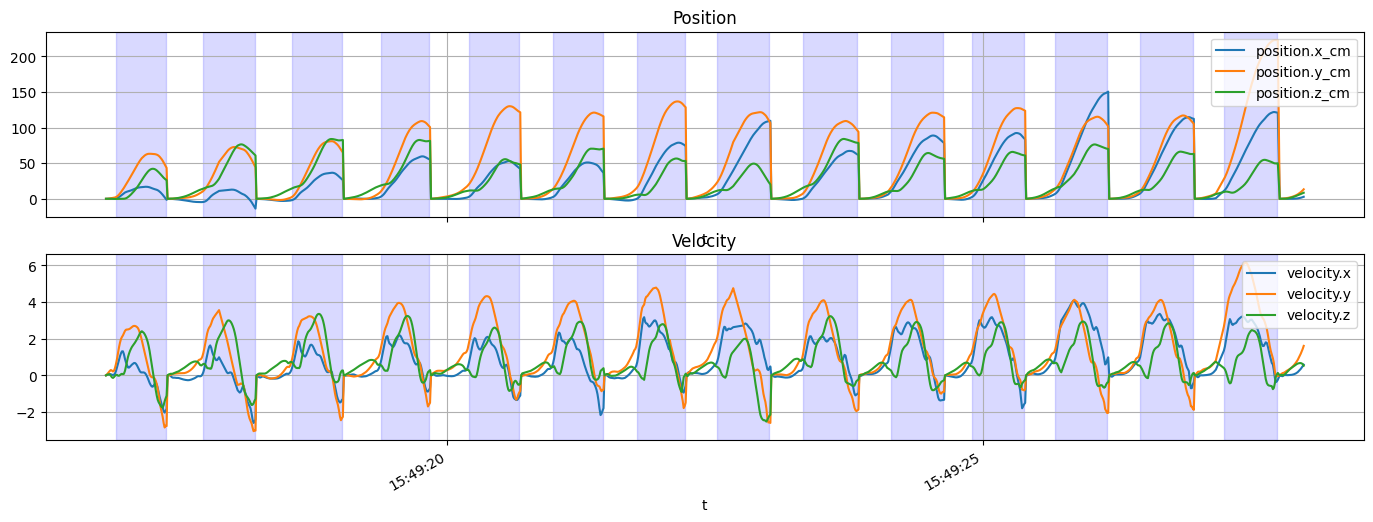

In [244]:
fig, (ax1, ax2) = plt.subplots(2, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper right')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper right')
ax2.grid()
ax2.set_title('Velocity')

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
fig.set_figheight(6)